In [4]:
# Check data directory
import os
os.listdir("FaceShape_Dataset")

['testing_set', 'training_set']

# Import libraries

In [5]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load data split train, val

In [6]:
from datasets import load_dataset
data_dir = "FaceShape_Dataset"

# load dataset
train_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "training_set"), split="train")
test_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "testing_set"), split="train")

# label2idx and idx2label
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
# split train, val
splits = train_ds.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)

Features {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['Heart', 'Oblong', 'Oval', 'Round', 'Square'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 3600
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 400
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})
Num labels 5
Label2Idx {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


In [7]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Visualize some images and labels

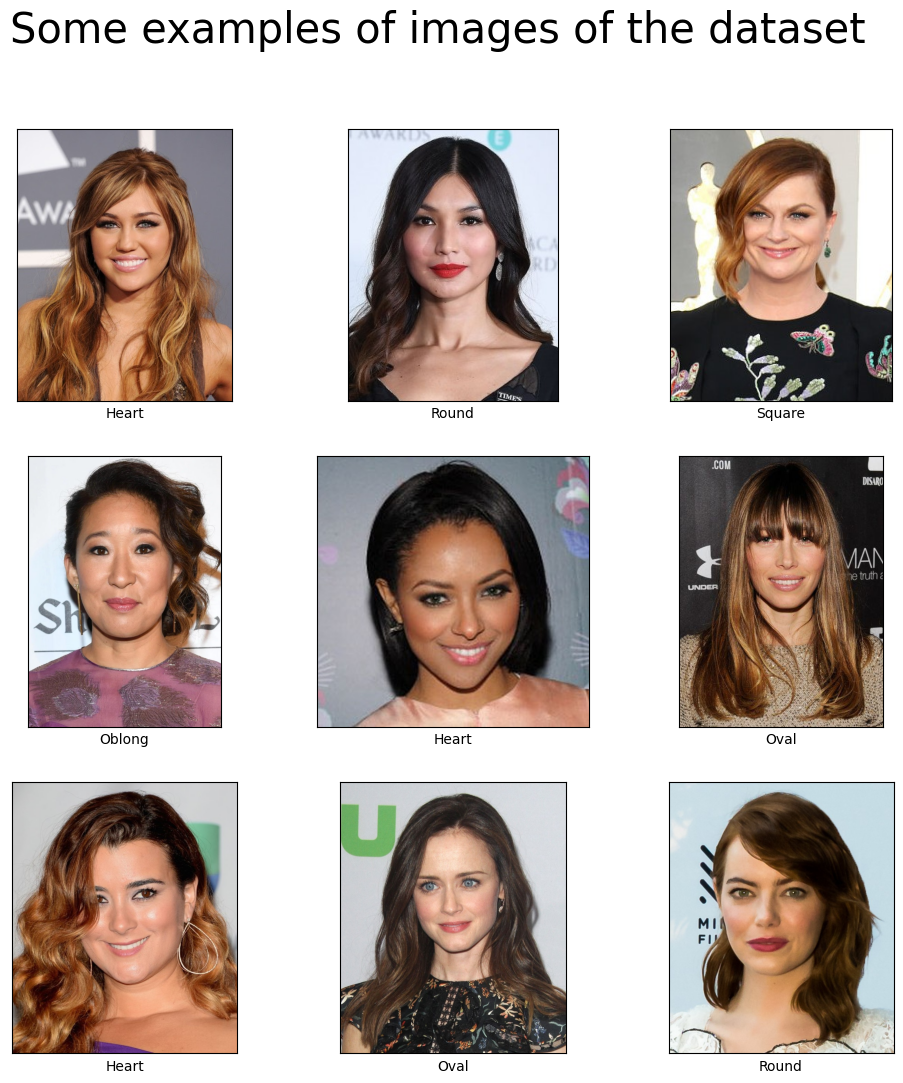

In [8]:
import cv2
import matplotlib.pyplot as plt  
from random import randint
list_idx = [randint(0, len(train_ds)) for i in range(9)]
def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the dataset", fontsize=30)
    for i, idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel(id2label[train_ds[idx]["label"]])
    plt.show()

display_examples()

# Transforms

In [9]:
from transformers import AutoFeatureExtractor
from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    RandomHorizontalFlip,
    RandomResizedCrop, 
    Resize, 
    ToTensor
)

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Extract width and height from feature_extractor.size dictionary
width = feature_extractor.size['width']
height = feature_extractor.size['height']

_train_transforms = Compose(
    [
        RandomResizedCrop(size=(width, height)),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

_val_transforms = Compose(
    [
        Resize(size=(width, height)),
        CenterCrop((width, height)),
        ToTensor(),
        normalize,
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)


C:\Users\Supran\AppData\Roaming\Python\Python311\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
pip install accelerate -U


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
feature_extractor.image_mean, feature_extractor.image_std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [12]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

# Dataloader

In [13]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

# Deffine the model

In [14]:
from transformers import SwinForImageClassification, SwinConfig

config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

# Load metric

In [16]:
from datasets import load_metric
import numpy as np

metric = load_metric(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

C:\Users\Supran\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [18]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
trainer.train()

                                                    
  5%|▌         | 113/2260 [19:58<5:10:57,  8.69s/it]

{'eval_loss': 1.494101881980896, 'eval_accuracy': 0.36, 'eval_runtime': 48.5039, 'eval_samples_per_second': 8.247, 'eval_steps_per_second': 0.268, 'epoch': 1.0}


                                                     
 10%|█         | 226/2260 [38:35<4:32:20,  8.03s/it]

{'eval_loss': 1.3426353931427002, 'eval_accuracy': 0.4025, 'eval_runtime': 43.8579, 'eval_samples_per_second': 9.12, 'eval_steps_per_second': 0.296, 'epoch': 2.0}


                                                     
 15%|█▌        | 339/2260 [58:53<4:41:18,  8.79s/it]

{'eval_loss': 1.1927531957626343, 'eval_accuracy': 0.53, 'eval_runtime': 47.6101, 'eval_samples_per_second': 8.402, 'eval_steps_per_second': 0.273, 'epoch': 3.0}


                                                      
 20%|██        | 452/2260 [1:19:25<4:26:42,  8.85s/it]

{'eval_loss': 1.062796950340271, 'eval_accuracy': 0.5975, 'eval_runtime': 47.8141, 'eval_samples_per_second': 8.366, 'eval_steps_per_second': 0.272, 'epoch': 4.0}


 22%|██▏       | 500/2260 [1:27:51<5:00:28, 10.24s/it] 

{'loss': 1.3243, 'learning_rate': 1.5575221238938054e-05, 'epoch': 4.42}


                                                      
 25%|██▌       | 565/2260 [1:39:18<4:04:17,  8.65s/it]

{'eval_loss': 1.0550466775894165, 'eval_accuracy': 0.5925, 'eval_runtime': 45.3248, 'eval_samples_per_second': 8.825, 'eval_steps_per_second': 0.287, 'epoch': 5.0}


                                                       
 30%|███       | 678/2260 [1:59:36<3:39:45,  8.34s/it]

{'eval_loss': 0.9256765842437744, 'eval_accuracy': 0.66, 'eval_runtime': 45.7293, 'eval_samples_per_second': 8.747, 'eval_steps_per_second': 0.284, 'epoch': 6.0}


                                                      
 35%|███▌      | 791/2260 [2:19:11<3:27:49,  8.49s/it]

{'eval_loss': 1.020145058631897, 'eval_accuracy': 0.5775, 'eval_runtime': 46.1244, 'eval_samples_per_second': 8.672, 'eval_steps_per_second': 0.282, 'epoch': 7.0}


                                                      
 40%|████      | 904/2260 [2:37:34<3:03:16,  8.11s/it]

{'eval_loss': 0.9627688527107239, 'eval_accuracy': 0.625, 'eval_runtime': 43.8905, 'eval_samples_per_second': 9.114, 'eval_steps_per_second': 0.296, 'epoch': 8.0}


 44%|████▍     | 1000/2260 [2:52:23<3:20:20,  9.54s/it]

{'loss': 0.9285, 'learning_rate': 1.1150442477876106e-05, 'epoch': 8.85}


                                                       
 45%|████▌     | 1017/2260 [2:55:46<2:47:59,  8.11s/it]

{'eval_loss': 0.8990830183029175, 'eval_accuracy': 0.6675, 'eval_runtime': 43.477, 'eval_samples_per_second': 9.2, 'eval_steps_per_second': 0.299, 'epoch': 9.0}


                                                       
 50%|█████     | 1130/2260 [3:15:02<2:45:27,  8.79s/it]

{'eval_loss': 0.8589968681335449, 'eval_accuracy': 0.6675, 'eval_runtime': 47.2687, 'eval_samples_per_second': 8.462, 'eval_steps_per_second': 0.275, 'epoch': 10.0}


                                                       
 55%|█████▌    | 1243/2260 [3:35:23<2:29:21,  8.81s/it]

{'eval_loss': 0.8138914704322815, 'eval_accuracy': 0.6875, 'eval_runtime': 46.8922, 'eval_samples_per_second': 8.53, 'eval_steps_per_second': 0.277, 'epoch': 11.0}


                                                       
 60%|██████    | 1356/2260 [3:56:04<1:57:20,  7.79s/it]

{'eval_loss': 0.8139771223068237, 'eval_accuracy': 0.71, 'eval_runtime': 43.4742, 'eval_samples_per_second': 9.201, 'eval_steps_per_second': 0.299, 'epoch': 12.0}


                                                       
 65%|██████▌   | 1469/2260 [4:15:53<1:46:24,  8.07s/it]

{'eval_loss': 0.8180482387542725, 'eval_accuracy': 0.68, 'eval_runtime': 42.8265, 'eval_samples_per_second': 9.34, 'eval_steps_per_second': 0.304, 'epoch': 13.0}


 66%|██████▋   | 1500/2260 [4:20:39<2:07:27, 10.06s/it]

{'loss': 0.7522, 'learning_rate': 6.72566371681416e-06, 'epoch': 13.27}


                                                       
 70%|███████   | 1582/2260 [4:35:27<1:38:59,  8.76s/it]

{'eval_loss': 0.8070248365402222, 'eval_accuracy': 0.72, 'eval_runtime': 46.5745, 'eval_samples_per_second': 8.588, 'eval_steps_per_second': 0.279, 'epoch': 14.0}


                                                       
 75%|███████▌  | 1695/2260 [4:57:01<1:23:05,  8.82s/it]

{'eval_loss': 0.7838932871818542, 'eval_accuracy': 0.7175, 'eval_runtime': 47.2276, 'eval_samples_per_second': 8.47, 'eval_steps_per_second': 0.275, 'epoch': 15.0}


                                                       
 80%|████████  | 1808/2260 [5:16:47<1:01:40,  8.19s/it]

{'eval_loss': 0.7686910033226013, 'eval_accuracy': 0.73, 'eval_runtime': 44.3312, 'eval_samples_per_second': 9.023, 'eval_steps_per_second': 0.293, 'epoch': 16.0}


                                                       
 85%|████████▌ | 1921/2260 [5:37:24<50:06,  8.87s/it]

{'eval_loss': 0.7648178339004517, 'eval_accuracy': 0.715, 'eval_runtime': 47.0078, 'eval_samples_per_second': 8.509, 'eval_steps_per_second': 0.277, 'epoch': 17.0}


 88%|████████▊ | 2000/2260 [5:51:21<45:55, 10.60s/it]  

{'loss': 0.6608, 'learning_rate': 2.3008849557522127e-06, 'epoch': 17.7}


                                                     
 90%|█████████ | 2034/2260 [5:58:07<33:47,  8.97s/it]

{'eval_loss': 0.7787513732910156, 'eval_accuracy': 0.7025, 'eval_runtime': 48.1872, 'eval_samples_per_second': 8.301, 'eval_steps_per_second': 0.27, 'epoch': 18.0}


                                                       
 95%|█████████▌| 2147/2260 [6:17:54<16:33,  8.79s/it]

{'eval_loss': 0.7657042145729065, 'eval_accuracy': 0.7175, 'eval_runtime': 47.1027, 'eval_samples_per_second': 8.492, 'eval_steps_per_second': 0.276, 'epoch': 19.0}


                                                     
100%|██████████| 2260/2260 [6:38:38<00:00,  8.87s/it]

{'eval_loss': 0.7634313702583313, 'eval_accuracy': 0.7225, 'eval_runtime': 48.3341, 'eval_samples_per_second': 8.276, 'eval_steps_per_second': 0.269, 'epoch': 20.0}


100%|██████████| 2260/2260 [6:38:39<00:00, 10.58s/it]

{'train_runtime': 23919.3542, 'train_samples_per_second': 3.01, 'train_steps_per_second': 0.094, 'train_loss': 0.8820688028251176, 'epoch': 20.0}


TrainOutput(global_step=2260, training_loss=0.8820688028251176, metrics={'train_runtime': 23919.3542, 'train_samples_per_second': 3.01, 'train_steps_per_second': 0.094, 'train_loss': 0.8820688028251176, 'epoch': 20.0})

# Validation

In [19]:
trainer.evaluate()

100%|██████████| 13/13 [00:40<00:00,  3.15s/it]


{'eval_loss': 0.7686910033226013,
 'eval_accuracy': 0.73,
 'eval_runtime': 44.6916,
 'eval_samples_per_second': 8.95,
 'eval_steps_per_second': 0.291,
 'epoch': 20.0}

# Evaluation on test set

In [20]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

100%|██████████| 32/32 [01:57<00:00,  3.66s/it]

{'test_loss': 0.7924020886421204, 'test_accuracy': 0.696, 'test_runtime': 121.4272, 'test_samples_per_second': 8.235, 'test_steps_per_second': 0.264}


# Classification report

In [21]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Heart       0.61      0.69      0.65       200
      Oblong       0.71      0.80      0.75       200
        Oval       0.69      0.47      0.56       200
       Round       0.69      0.74      0.71       200
      Square       0.79      0.79      0.79       200

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.69      1000
weighted avg       0.70      0.70      0.69      1000



# Confusion matrix

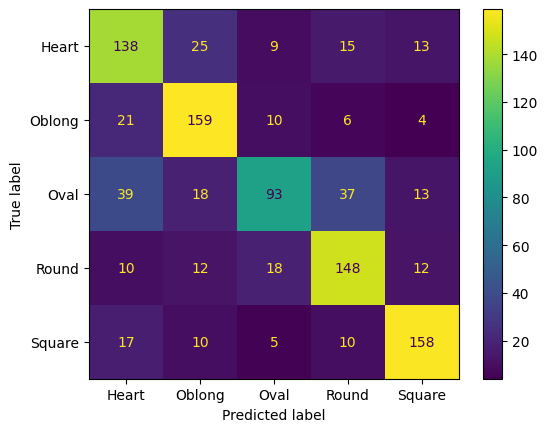

In [22]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Visualize some predicted results

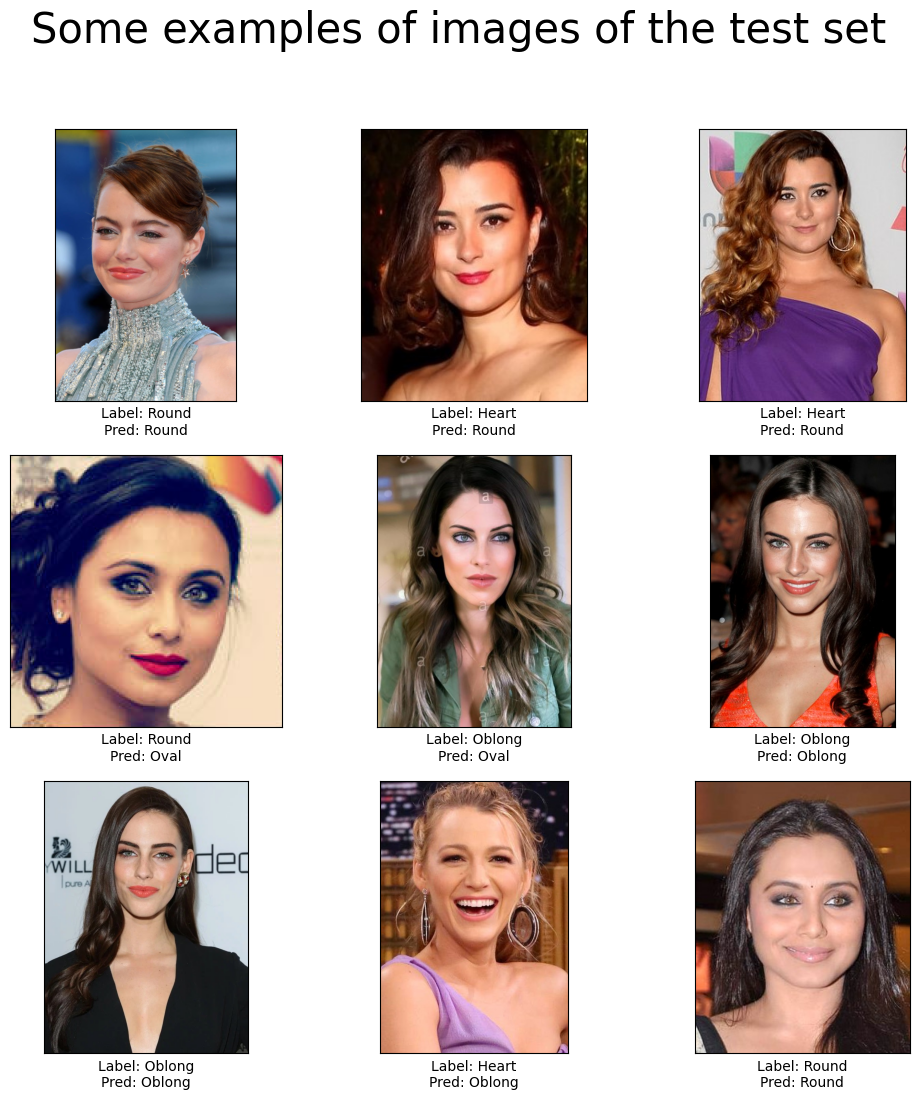

In [23]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(9)]

def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the test set", fontsize=30)
    for i,idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel("Label: "+id2label[y_true[idx]]+"\nPred: "+id2label[y_pred[idx]])
    plt.show()

display_examples()

In [26]:
from transformers import SwinForImageClassification, SwinConfig

# Assuming model is your trained model

# Save the trained model
model.save_pretrained("aftermid70.keras")


In [1]:
trainer.save_model("acc70keras8")

NameError: name 'trainer' is not defined